# Phase 3 Data Science Training Notebook

In [108]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [109]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [110]:
data_batch_1 = unpickle("data_batch_1")
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [111]:
labelNames = unpickle("batches.meta")
labelNames.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [112]:
print(labelNames[b'num_cases_per_batch'])
print(labelNames[b'label_names'])
labelNames.values()

10000
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


dict_values([10000, [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], 3072])

In [113]:
labelList = labelNames[b'label_names']

In [114]:
data_batch_1[b'batch_label']

b'training batch 1 of 5'

In [115]:
print(len(data_batch_1[b'labels']))
print(max(data_batch_1[b'labels']))
print(min(data_batch_1[b'labels']))
labels = data_batch_1[b'labels']

10000
9
0


In [116]:
indexForEach = []
for i in range (10):
    temp = []
    for idx, label in enumerate(labels):
        if len(temp) == 5:
            indexForEach.append(temp)
            break
        if label == i:
            temp.append(idx)

indexForEach

[[29, 30, 35, 49, 77],
 [4, 5, 32, 44, 45],
 [6, 13, 18, 24, 41],
 [9, 17, 21, 26, 33],
 [3, 10, 20, 28, 34],
 [27, 40, 51, 56, 70],
 [0, 19, 22, 23, 25],
 [7, 11, 12, 37, 43],
 [8, 62, 69, 92, 100],
 [1, 2, 14, 15, 16]]

In [117]:
data_batch_1[b'data'].shape

(10000, 3072)

In [118]:
import matplotlib.pyplot as plt

def getFiveImages(toShow, index):
    sampleImages = []
    for i in range (5):
        temp =  data_batch_1[b'data'][toShow[i]]
        temp = temp.reshape(3,32,32)
        temp = temp.transpose(1,2,0)
        sampleImages.append(temp)
    fig, axs = plt.subplots(1, 5, constrained_layout=True)
    fig.suptitle("Label " + index + " (" + str(labelList[int(index)]).replace("b'", "").replace("'", "") + ")", fontsize=16)
    fig.set_figwidth(15)
    for j in range (5):
        axs[j].imshow(sampleImages[j])



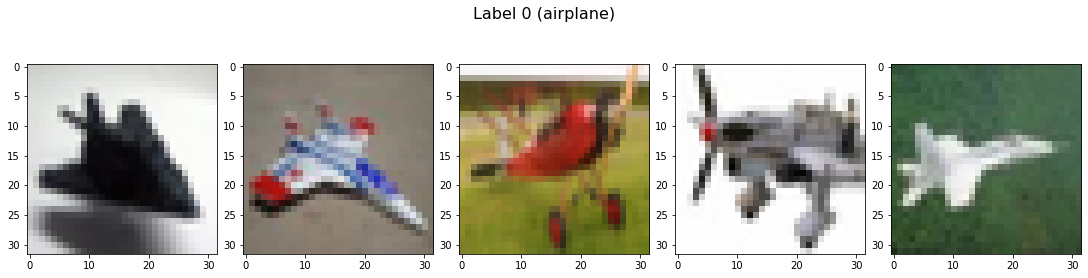

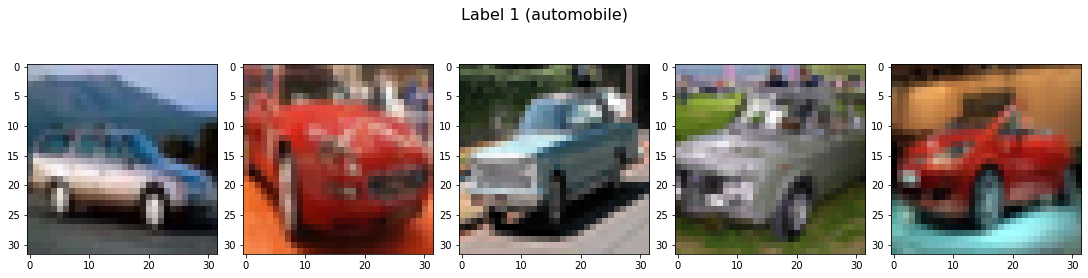

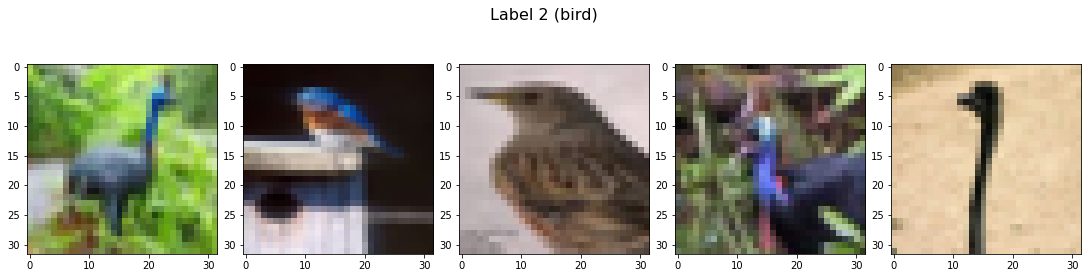

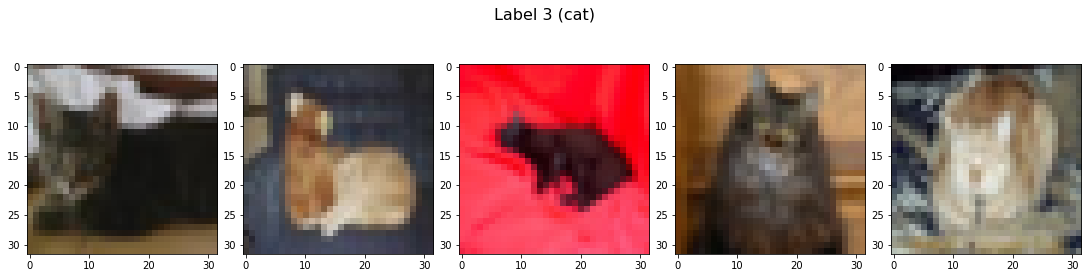

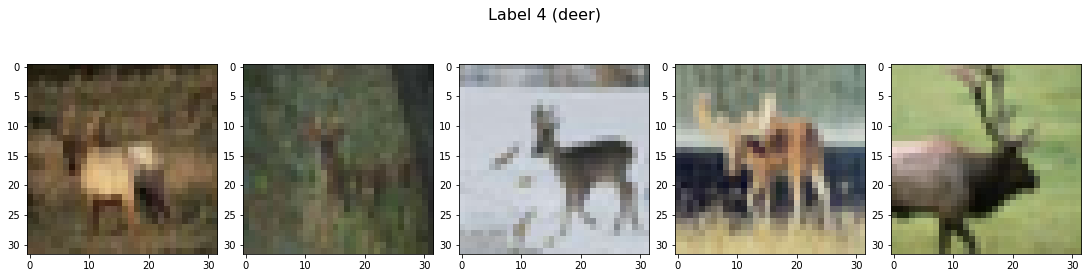

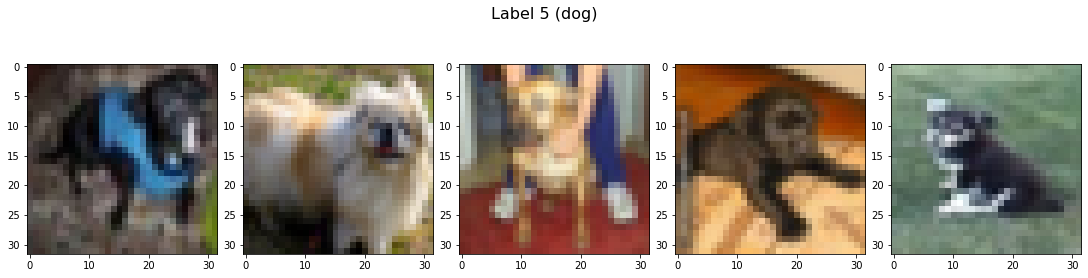

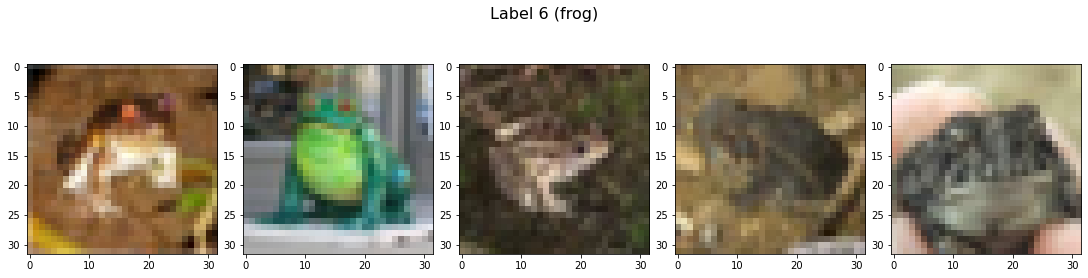

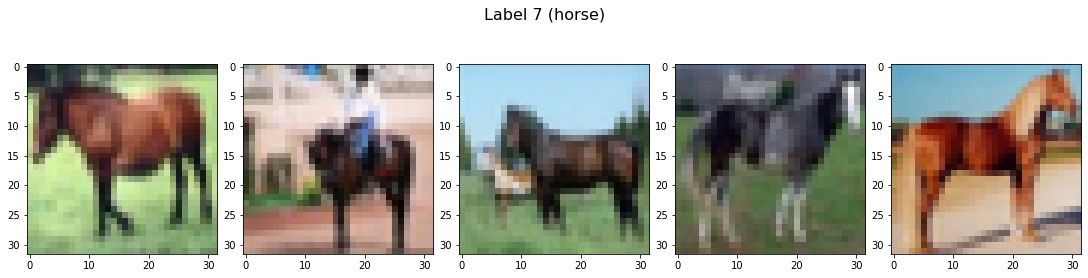

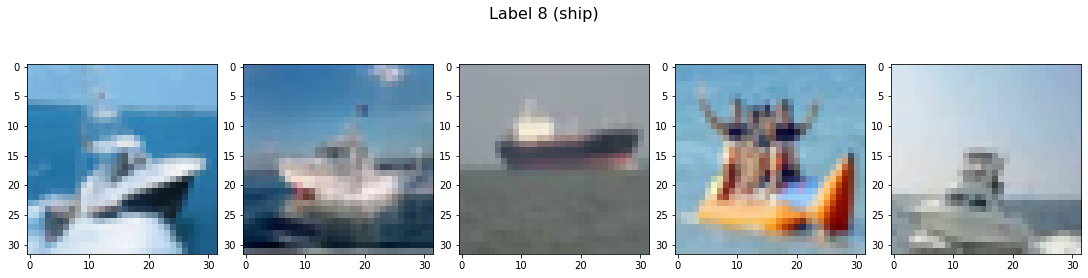

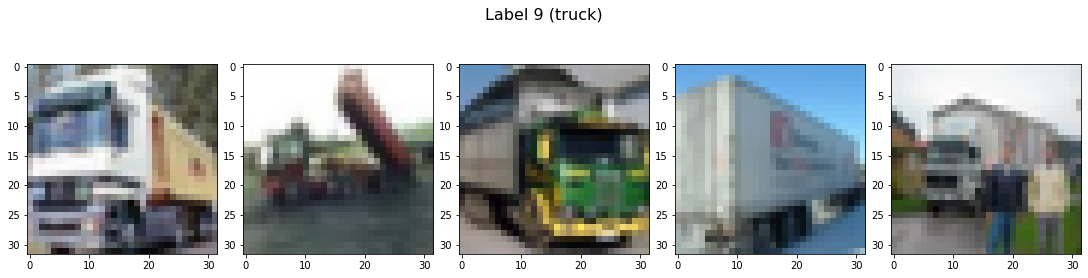

In [119]:
for i in range (10):
    getFiveImages(indexForEach[i], str(i))

I'd like to use label 2, which appears to be birds

# Data Processing

Now lets unpickle the rest of the files and then see how we can use it to fit a model

In [120]:
testingData = unpickle("test_batch")
data_batch_2 = unpickle("data_batch_2")
data_batch_3 = unpickle("data_batch_3")
data_batch_4 = unpickle("data_batch_4")
data_batch_5 = unpickle("data_batch_5")


To avoid data imbalance, ideally we will have an even amount of each of the labels, all sampled from the different datasets. 

In [121]:
print(len(testingData[b'labels']))
testingData[b'labels'].count(2)



10000


1000

In [122]:
batches = []
batches.append(data_batch_1)
batches.append(data_batch_2)
batches.append(data_batch_3)
batches.append(data_batch_4)
batches.append(data_batch_5)
batches

[{b'batch_label': b'training batch 1 of 5',
  b'labels': [6,
   9,
   9,
   4,
   1,
   1,
   2,
   7,
   8,
   3,
   4,
   7,
   7,
   2,
   9,
   9,
   9,
   3,
   2,
   6,
   4,
   3,
   6,
   6,
   2,
   6,
   3,
   5,
   4,
   0,
   0,
   9,
   1,
   3,
   4,
   0,
   3,
   7,
   3,
   3,
   5,
   2,
   2,
   7,
   1,
   1,
   1,
   2,
   2,
   0,
   9,
   5,
   7,
   9,
   2,
   2,
   5,
   2,
   4,
   3,
   1,
   1,
   8,
   2,
   1,
   1,
   4,
   9,
   7,
   8,
   5,
   9,
   6,
   7,
   3,
   1,
   9,
   0,
   3,
   1,
   3,
   5,
   4,
   5,
   7,
   7,
   4,
   7,
   9,
   4,
   2,
   3,
   8,
   0,
   1,
   6,
   1,
   1,
   4,
   1,
   8,
   3,
   9,
   6,
   6,
   1,
   8,
   5,
   2,
   9,
   9,
   8,
   1,
   7,
   7,
   0,
   0,
   6,
   9,
   1,
   2,
   2,
   9,
   2,
   6,
   6,
   1,
   9,
   5,
   0,
   4,
   7,
   6,
   7,
   1,
   8,
   1,
   1,
   2,
   8,
   1,
   3,
   3,
   6,
   2,
   4,
   9,
   9,
   5,
   4,
   3,
   6,
   7,
   4,
   6,
   8,
   5,
   

In [123]:
def formatData(entry):
    temp = entry
    temp = temp.reshape(3,32,32)
    temp = temp.transpose(1,2,0)
    return temp

In [129]:
combined = batches[0][b'data']
for i in range (1,5):
    temp = batches[i][b'data']
    combined = np.concatenate((combined, batches[i][b'data']))
    
len(combined)


50000

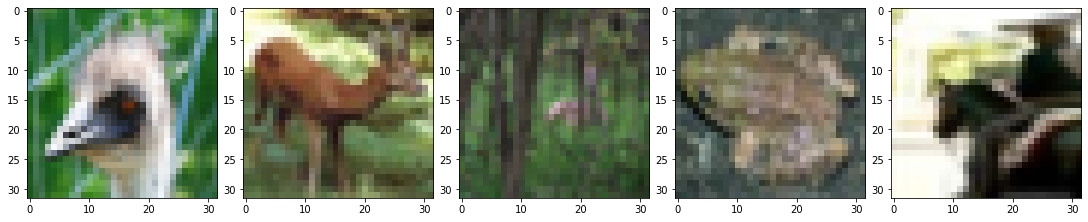

In [131]:
import random
random.seed(69)
testingData = random.sample(list(combined),5000)
for idx,val in enumerate(testingData):
    testingData[idx] = formatData(val)

fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figwidth(15)
for j in range (5):
    axs[j].imshow(testingData[j])


In [ ]:


train_x = data_batch_1[b'data']

train_y = data_batch_1[b'labels']

test_x = np.random.randint(0,255,size=(1000,3,32,32))
test_y = np.random.randint(0,255,size=(1000))

# Data Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime


In [ ]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(3,32,32))) # Input layer.

    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.

    model.add(layers.Dense(40, activation="relu")) # Example Hidden Layer 1. Has 40 Nodes.
    model.add(layers.Dense(25, activation="sigmoid")) # Example Hidden Layer 2. Has 25 Nodes.
    model.add(layers.Dense(15, activation="tanh")) # Example Hidden Layer 3. Has 15 Nodes.

    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability")) # Output layer.

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01),
        loss=losses.MeanAbsoluteError(),
        metrics=['accuracy']
    )

    return model

In [ ]:
model = generateModel()

log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=50000,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})